# Visual Grounding
## Assignment for the Deep Learning Course at UniTn (2023)
Olha Khomyn, Filippo Momentè, Decebal Cernei

---

## Introduction

---

The objective of the assignment was to fine-tune CLIP for the visual grounding task, and use RefCOCOg as the dataset for training and evaluating the performances of the new architecture.

Given the given the relatively recent successes of Tranformers [(*Vaswani et al. 2017*)](https://arxiv.org/pdf/1706.03762.pdf) in performing language and vision multimodal tasks, including visual grounding [(*Deng et al. 2021*)](https://arxiv.org/pdf/2104.08541.pdf), [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf), [(*Du et al. 2022*)](https://ieeexplore.ieee.org/document/9859880), the application of Tranformers to such task appears very promising.

These works all demonstrated that by using Transformers as fusion modules for learning joint representaiton of visual and textual features, it is possible to reduce the length of the visual grounding pipeline in an effective way, therefore decreasing the number of human-introduced assumptions and the reliance of the performances on particular modules composing the pipeline, which could cause bottlenecks when they perform much worse than other modules.

In particular, earlier approaches to visual grounding were maily based on two-stage methods. Here, an object detector is employed in order to individuate a number of object proposals, which are then matched against textual queries to find the best match. While more recently several works have already reduced the length of the visual grounding pipeline by defining single-stage grounding architectures [(*Yang et al. 2019*)](https://arxiv.org/pdf/1908.06354.pdf), [(*Yang et al. 2020*)](https://arxiv.org/pdf/2008.01059.pdf), [(*Sadhu et al. 2019*)](https://arxiv.org/pdf/1908.07129.pdf) these methods still made use of pre-defined grids, or anchors which have been succesfully replaced by the Transformer fusion modules.

---

Inspired by the achievements obtained in particular by [(*Deng et al. 2021*)](https://arxiv.org/pdf/2104.08541.pdf) and [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf), we propose here an architecture composed of a visual and a language encoders, on top of which is placed a fusion module composed by stacks of Transformer encoders, whose output is then passed to a regression module outputting 4 coordinates.

The visual and language encoders are slightly modified versions of those of CLIP [(*Radford et al. 2021*)](https://arxiv.org/pdf/2103.00020.pdf).

## Methods

---
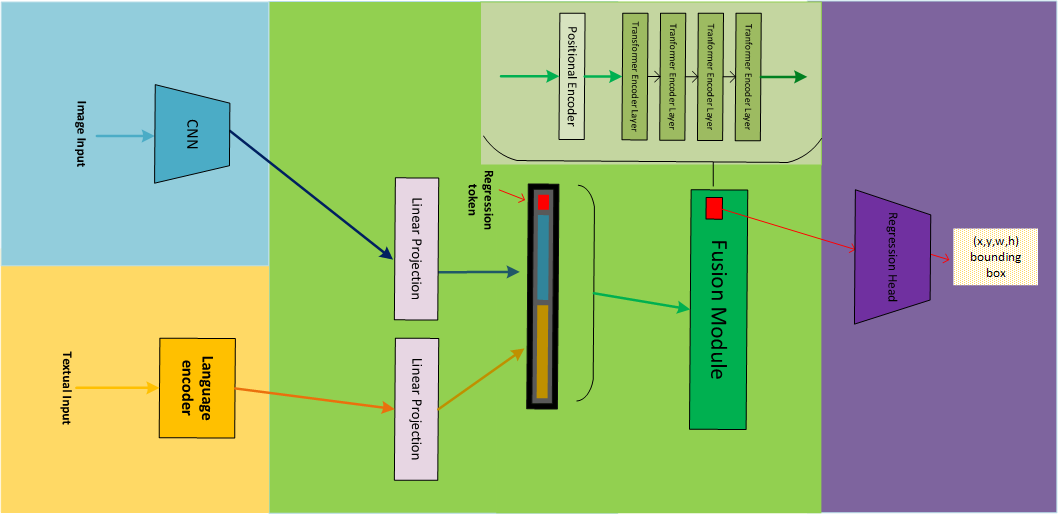

(*Figure 1: Our Final Architecture*)

---


First, we have pre-processed the images and computed the padding mask on them.
Then, we have obtained the image features by passing it through the CLIP vision encoder and the associated prompt by passing it through the CLIP text encoder.  Both encoders have been slightly modified in order to return the last hidden layers instead of the global image and text encodings.

On the top of CLIP vision and text encoders we have then placed a Transformer-based fusion model that we have built.

This model's purpose is to fuse the textual features together with the visual features.
The input consists of visual and textual features obtained from CLIP, concatenated together with a special regression token that represents a joint representation of both image and text.
This regression token is passed through a MLP model with one hidden layer. It directly predicts 4 coordinates of a bounding box in xywh format.  

The learning objective of the model is a sum of Complete IoU and smooth L1 loss, selected after measuring the effects of various losses and combination of losses on our model.

In order to evaluate the performances of our model, we report the number of predicted bounding boxes whose IoU with the ground truths is higher than 50%, divided by the total number of the predictions. We report also the mean IOU.

---

Additionally, we have also attempted pre-training the fusion layer on image-text matching task (ITM). The model was trained to predict whether a pair of an image and text is positive or negative. Negative examples have been sampled by randomly choosing unmatched image for some prompt.

We have observed that the pre-training didn't provide any improvement to our best performing architecture, and a reason could be the lack of resources for training the model for a sufficient number of epochs and/or the need of much bigger dataset (more explanation will be provided below).

---

Another path we have followed in order to improve the performance of our best performing architecture is that of exploiting the information contained at the intermediate layers of the visual encoder (this was inspired by [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf)). For this reason, we have also modified CLIP in order to return the features of one selected intermediate layer of ResNet-50. We have fused separately the intermediate hidden layer and the output of the last hidden layer of CLIP's visual encoder with the language features. We have then concatenated these together with a regression token and performed the same operations described above.

We have observed that performing these operations slightly decreased the performances, while requiring exponentially more resources at the same time.

---
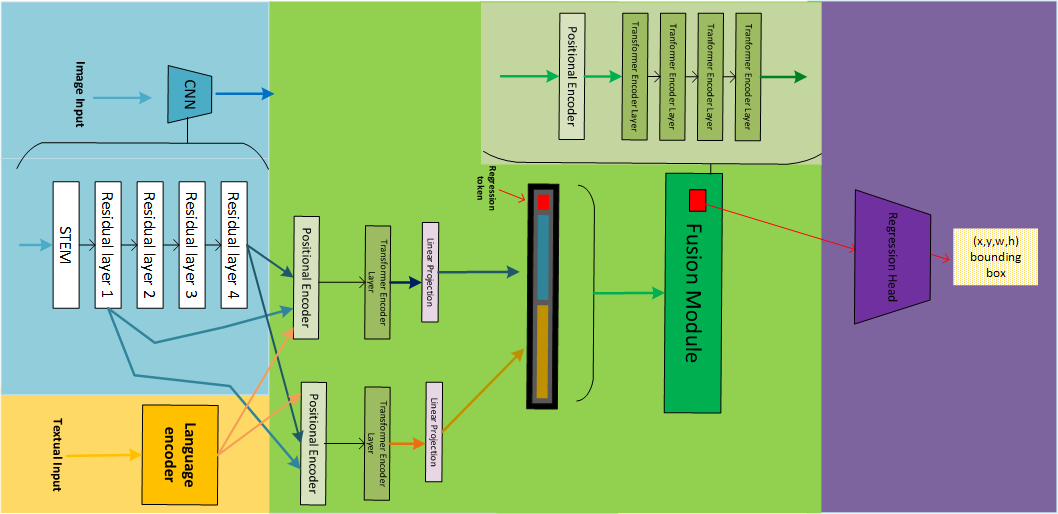


##### (*Figure 2: Alternative architecture exploiting information from one intermediate layer of the visual encoder*)
---

The notebook presents more detailed information regarding each passage and operation we performed. Along with our best performing architecture, we have also decided to showcase the attempts to add pre-training and the use of intermediate features even though they didn't provide performance improvements because we believe they are still meaningful for educational purposes.

# Training details

We started by training the model using a batch size of 64, with learning rate of 0.0001 and weight decay equals to 0.00001 for 30 epochs.

Then, since the accuracy wasn't improving much, we decided to increase the learning rate: firstly we tried with 0.0006 but was too high so we end up with a value of 0.0002.


After 15 epochs the model started to perform worse and overfit. An early-stop occured so we choose a lower learning rate and a higher weight decay, respectively 0.00005 and 0.0001. This helped us to avoid early-stopping and to reach a better accuracy, training for other 20 epochs more.

For the last epochs we trained the model on an augmented dataset. We augmented the dataset by taking all annotation for each image. So if a sample had one image and three annotations, we create three samples by appying the transformations on the original image. We decided to train on a bigger dataset because the learning became slow and the model started to overfit. With the use of the augmented dataset we were able to mitigate these issues.

To sum up, we trained the model with batch size of 64 for 65 epochs varying the parameters.


![picture](https://drive.google.com/uc?export=view&id=1BKB_IFu1Jjma_geeca0zjKzUZL4yZnX8)

(*Figure 3: Timeline representing our training process*)

# Results
The results obtained by our best performing architecture, although lower compared to the state-of-the art works, appear quite interesting from an educational perspective.
Our architecture, despite its relative simplicity and a shorter training period compared to [(*Deng et al. 2021*)](https://arxiv.org/pdf/2104.08541.pdf), [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf), still managed to reach an accuracy of 0.39, and a mean IoU of 0.41. By measuring the performances on the test set before and after performing the training, we have demonstrated that this result was an effect of the training.

The version with the intermediate layer features, and the effect of using the pre-trained weights have not been reported, as we have measured the performances of these additions only on a small subset of 2000 samples early on and then focused all of our training resources only on the best performing architecture, which has received further improvements from the tuning of hyperparameters later on.

# Conclusion

Our goal was fine-tuning CLIP for performing the visual grounding task. Given that CLIP has not been trained for that but just for general image-text matching.
Many of the traditional methods prior to the introduction of Transformers in vision were based on approaches which were too reliant on candidate objects or human-introduced constraints such as grids or anchors.
We have attempted to base our work on the most recent advancements in visual grounding, which included the use of Transformers in order to learn joint representation of  visual and language inputs.

Using CLIP as a foundation for visual grounding architectures is something that is worth investigating further. Given the limited resources available, it is hard to tell whether its fine-tuning could lead to state-of-the-art results, however it is likely that more training and a larger dataset could have demonstrated its efficacy even more.

Something else that is worth investigating is how to extract succesfully features from the intermediate layers of CLIP and use them to enhance the performances of the grounding architecture. Its structure makes it more challenging compared to a Transformer-based visual encoder, however given the fact that previous layers encode different features, it would be meaningful to be able to exploit this information.

## Our Contributions

In this section, we would like to highlight our major contributions.
Despite following the same structure of TransVG [(*Deng et al. 2021*)](https://arxiv.org/pdf/2104.08541.pdf), our network is using CLIP's visual and language encoders, which have been trained jointly to predict image and text pairings, while TransVG employs two separate encoders with no jointly pre-trained weights. The structure of these encoders is also different.

While the visual encoder of TransVG is composed by a ResNet backbone and a stack of Transformer encoders on top of it, ours is simply a modified ResNet.

On the other hand, compared to CLIP, we have modified its encoders slightly.  In order to avoid the originally performed downsampling in the visual encoder, we have removed the last two-dimensional attention pooling operation. In the language encoder, we modified the last operation and obtained the embeddings for each token. We have observed this to improve the performances.

We have also made changes to the CLIP's pre-processing pipeline. We have added various image transformation operations (random brightness, random contrast, random saturation and random hue), removed center crop as it was not suited for visual grounding, and we have adapted the bounding boxes' coordinates to these changes.

---

We have changed CLIP's textual prompt into one that has been working well for visual grounding in PseudoQ [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf).

---

We have applied L2 normalization to the output of the visual and textual encoders, something that was not done in TransVG or PseudoQ.

---

Compared to TransVG and derived architectures [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf), we have applied the positional encoding before passing the joint vision-language input to the Transformer encoder layers, and our positional encoding is computed similarly to the original Transformers paper, while in these architectures the positional encoding was a learnable embedding. We have also applied a different dropout (0.2 vs no dropout in TransVG)



---

Our fusion module is also different from that of TransVG in a few ways. We have used four Transformer encoders instead of six, we have computed the positional encoding outside of it as already mentioned, we apply a much stronger dropout to the encoder layers (0.4 vs 0.1 in TransVG).

---

We have also measured and analyzed the effect of various IoU-based losses (GIoU [(*Rezatofighi et al. 2019*)](https://arxiv.org/pdf/1902.09630.pdf), DIoU and CIoU [(*Zheng et al. 2019*)](https://arxiv.org/pdf/1911.08287.pdf), and their joint combination with smooth L1 loss and Focal loss [(*Lin et al. 2018*)](https://arxiv.org/pdf/1708.02002.pdf), observing that CIoU combined with smooth L1 loss were the best combination.

---

Although it did not lead to better performances, it is important to remark our attempt to pre-train our Transformer-based visual grounding architecture to perform image-text matching. This is a common learning objective for general vision-language multimodal tasks and it has been used on pre-trained models which also performed well on zero-shot visual grounding such as [(*Li et al. 2021*)](https://arxiv.org/pdf/2107.07651.pdf). For this reason, we attempted to pre-train our model before actually training it for visual grounding.
Later in the notebook we will present some assumptions and extended details about why we didn't see meaningful improvements.

---

Finally another interesting contribution is represented by our attempt to extract features from intermediate layers of the visual encoder, not just from the last layer, something that was already attempted succefully by PseudoQ [(*Jiang et al. 2022*)](https://arxiv.org/pdf/2203.08481.pdf).  

However our implementation differs substantially from that of the above mentioned work. In PseudoQ, the visual encoder was exactly as in TransVG: a ResNet backbone and a stack of Transformer encoders on top.

Here, they extracted the output of every Transformer encoder, and calculated a cross-modality attention on this output concatenated with the language encoding, then they concatenated language with every visual output and performed the same cross-attention (specular operation).
The result of the first set of cross-attention fusion operations was concatenated again and a linear projection was applied. The same for the second set.
The projected output was once more concatenated together with a regression token.
Finally, the resulting concatenated array was passed to a stack of Transformer encoding layers identical to that of TransVG, and then the regression token was leveraged for the bounding box coordinate prediction.

In our case, our visual encoder was a ResNet-50. While Transformer layers all have the same size, in our case every layer returns an output of different size compared to other layers. So we had to consider this and adapt the dimension of the outputs to have all the same size. For this purpose we have attempted both Average Pooling and Max Pooling to downsample the output, and we used a convolutional layer to change the channel dimension.
Then, we performed the same operations as above, but instead of a cross-modality attention module we have calculated the positional encoding and passed the output to 1 Transformer encoder layer.
Then, we have concatenated the result similarly to PseudoQ and passed it through our own fusion module (which has some differences compared to that of TransVG).
Unfortunately, because of limited resources, we have been able to do this only for one hidden layer and use a single encoder layer, something that likely reduced the possibility of success of our idea.
We have observed that this operations reduced slightly the accuracy of our model, rather than increasing it as we expected.
Moreover, it is possible that the adaptations we have made to the feature dimensionality might have affected the final result, and that the cross-modality attention is a more effective fusion method than our single Transformer encoder.


---

# Implementation and additional details

In [ ]:
import os
import json
import math
import copy

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

from tqdm import tqdm

from sklearn.metrics import f1_score

from typing import Optional, List, Dict

# Part 1: Obtaining the Dataset

## Download of the Dataset

In [ ]:
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq

Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [01:54<00:00, 117MB/s]


## Unzip

In [ ]:
!tar -xvzf /content/refcocog.tar.gz

## Reading the instance annotation file
The instance annotation file contains some attibutes of the images such as segmentation, area, category_id, etc. For our task we are only interested in the bbox attribute that locates the object referenced by an annotation. The file is converted into a a Pandas dataframe, since it is much more efficient and practical than dealing with the plain list.

In [ ]:
instance_file = open("/content/refcocog/annotations/instances.json") # open the instances file
annotations = json.load(instance_file)['annotations'] # read it into list of jsons
instance_file.close() # close the file

annotations = pd.DataFrame(annotations) # convert list of dictionaries to a dataframe to improve efficiency
annotations.head(5)

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[21.11, 239.09, 16.31, 274.6, 198.65, 349.45,...",48667.84090,0,131074,"[16.31, 141.21, 421.29, 208.24]",65,318235
1,"[[474.17, 215.44, 342.4, 201.98, 317.39, 195.2...",10501.20610,0,131074,"[299.12, 136.58, 241.7, 88.85]",65,319598
2,"[[326.4, 318.87, 320.05, 305.25, 323.68, 274.8...",3110.01535,0,131074,"[320.05, 248.05, 79.89, 83.07]",31,1174042
3,"[[283.47, 194.46, 271.43, 192.79, 274.44, 189....",39.81120,0,131074,"[271.43, 189.61, 14.22, 4.85]",75,1630619
4,"[[320.17, 195.66, 319.05, 221.23, 425.78, 234....",6405.16950,0,131074,"[319.05, 195.66, 184.54, 98.94]",65,1957252


## Reading a file containing file names of the images in the dataset and the information for partitioning them into train/test/val.

The file is in the pickle format, which we convert into Pandas dataframe. We also add the full data path for the images.  
We chose the refs(umd).p partition as required by the assignment.


In [ ]:
partition = pd.read_pickle('/content/refcocog/annotations/refs(umd).p') # read Pickle file

partition = pd.DataFrame.from_records(partition) # convert it to the dataframe
root_dir = './refcocog/images/'

# add full path to the dataframe
def add_img_path(row):
    image_name = row['file_name']
    return os.path.join(root_dir,image_name[:image_name.rindex('_')] + ".jpg") # join root_dir and file_name to obtain the full path

partition['image_name'] = partition.apply(lambda row: add_img_path(row), axis=1) # apply for all rows
partition.head(5)

,image_id,split,sentences,file_name,category_id,ann_id,sent_ids,ref_id,image_name
0,380440,test,"[{'tokens': ['the', 'man', 'in', 'yellow', 'co...",COCO_train2014_000000380440_491042.jpg,1,491042,"[8, 9]",0,./refcocog/images/COCO_train2014_000000380440.jpg
1,419645,test,"[{'tokens': ['there', 'is', 'red', 'colored', ...",COCO_train2014_000000419645_398406.jpg,8,398406,"[10, 11]",1,./refcocog/images/COCO_train2014_000000419645.jpg
2,478885,test,"[{'tokens': ['a', 'apple', 'desktop', 'compute...",COCO_train2014_000000478885_124383.jpg,72,124383,"[14, 15]",2,./refcocog/images/COCO_train2014_000000478885.jpg
3,323240,test,"[{'tokens': ['a', 'girl', 'wearing', 'glasses'...",COCO_train2014_000000323240_192943.jpg,1,192943,"[31, 32]",3,./refcocog/images/COCO_train2014_000000323240.jpg
4,41700,test,"[{'tokens': ['woman', 'in', 'coveralls'], 'raw...",COCO_train2014_000000041700_197196.jpg,1,197196,"[37, 38]",4,./refcocog/images/COCO_train2014_000000041700.jpg


# Part 2: Dataset Preprocessing

## Loading CLIP
We are already loading CLIP here because we want to preprocess the dataset using its functions, since our architecture is going to fine-tune it.
We however made some changes to the pre-processing pipeline compared to CLIP, as we have observed them to bring better results.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip

clip_model, clip_preprocess = clip.load("RN50")

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 125MiB/s]


## Finding the annotation with the highest similarity with the image
In RefCOCOg, each image is generally associated with more than one annotation, although they all refer to the same object.  Given that the CLIP model has been trained to predict the similarity between images and captions, we have employed its capabilities in order to select only the textual annotation that has the highest similarity with an image among all the annotations in the dataset. This way, we aimed to train our model only with those annotations which appeared more similar to the image according to CLIP. This operation has only been done on the training set whereas we keep all annotations for the validation and test sets.

The reason for performing this operation was to reduce the size of the training set in a reasoned way, rather than removing random image-text pairs. Reducing the training set was decided to rationalize the limited resources we had for training.

The function below has been executed once and the results have been saved to the file as it requires a significant running time.

In [ ]:
def find_best_matching_ann(row):
    img = Image.open(row['image_name'])

    # preprocess the image to CLIP format
    img = clip_preprocess(img)
    annotations = [r['raw'] for r in row['sentences']]

    if row['split'] == 'test' or row['split'] == 'val':
      return annotations

    # convert image to tensor
    image_input = torch.tensor(np.stack([img for _ in annotations])).to('cuda')

    # tokenize annotation with the mothod provided by clip
    text_tokens = clip.tokenize(annotations).to('cuda')

    # extract features
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input).float()
        text_features = clip_model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # compute similarity
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    # find the index of the most similiar annotation for the given image
    max_sim = similarity.argmax(axis=0)[0]
    return annotations[max_sim]


# due to the time required to execute this function, it has been done once and saved to the file, uncomment the lines below in case you want to run it again
#clip_model.eval()
#clip_model.to('cuda')
#partition['max_sim_sent'] = partition.apply(lambda row: find_best_matching_ann(row), axis=1)
#partition = partition.explode('max_sim_sent', ignore_index=True)
#partition.to_csv('max_sim.csv')

In [ ]:
!gdown 1htbdqQMCLBwZa0pISVJa_8k_TYtNHBC6 # download the file with the best matching annotations

partition = pd.read_csv('/content/max_sim.csv')

partition.head(5)

Downloading...
From: https://drive.google.com/uc?id=1htbdqQMCLBwZa0pISVJa_8k_TYtNHBC6
To: /content/max_sim.csv
100% 33.0M/33.0M [00:00<00:00, 148MB/s]


,Unnamed: 0,image_id,split,sentences,file_name,category_id,ann_id,sent_ids,ref_id,image_name,max_sim_sent
0,0,380440,test,"[{'tokens': ['the', 'man', 'in', 'yellow', 'co...",COCO_train2014_000000380440_491042.jpg,1,491042,"[8, 9]",0,./refcocog/images/COCO_train2014_000000380440.jpg,the man in yellow coat
1,1,380440,test,"[{'tokens': ['the', 'man', 'in', 'yellow', 'co...",COCO_train2014_000000380440_491042.jpg,1,491042,"[8, 9]",0,./refcocog/images/COCO_train2014_000000380440.jpg,Skiier in red pants.
2,2,419645,test,"[{'tokens': ['there', 'is', 'red', 'colored', ...",COCO_train2014_000000419645_398406.jpg,8,398406,"[10, 11]",1,./refcocog/images/COCO_train2014_000000419645.jpg,There is red colored truck in between the othe...
3,3,419645,test,"[{'tokens': ['there', 'is', 'red', 'colored', ...",COCO_train2014_000000419645_398406.jpg,8,398406,"[10, 11]",1,./refcocog/images/COCO_train2014_000000419645.jpg,A shiny red vintage pickup truck
4,4,478885,test,"[{'tokens': ['a', 'apple', 'desktop', 'compute...",COCO_train2014_000000478885_124383.jpg,72,124383,"[14, 15]",2,./refcocog/images/COCO_train2014_000000478885.jpg,A apple desktop computer


We repeat the operation for the pre-training. The file is just an old version where we reduced also the size of the test set, taking only the best matching annotations also for the test set images.
We kept the old file for the pre-training because it was not necessary to change it, since more test samples would not change the results we got when we initialized our main model with the pre-trained weights.

In [ ]:
!gdown 1oOBDvkjrzFvYytlak2bZVBNxlT9hOsRr # download the file with the best matching annotations

par_pretraining = pd.read_csv('/content/max.csv')

Downloading...
From: https://drive.google.com/uc?id=1oOBDvkjrzFvYytlak2bZVBNxlT9hOsRr
To: /content/max.csv
100% 29.0M/29.0M [00:00<00:00, 140MB/s]


## Making the prompts better suited for a visual grounding task
As proposed in [this paper](https://arxiv.org/pdf/2203.08481.pdf), we add "*find the region that corresponds to the description*" to the beginning of each annotation (we only kept the best matching annotations found in the previous step), since building prompts this way has been observed to impove the performance.

As this is a visual grounding task, the aim is to locate the object, thus this prompt is the more suitable, then the standard one proposed CLIP, which is "*the photo of*".

In [ ]:
prompt = "find the region that corresponds to the description "

partition['prompt'] = partition.apply(lambda row: prompt + row['max_sim_sent'].lower(), axis=1)

## Image Preprocessing
In this section, we take the CLIP image preprocessing function, and adapt it to our needs.

In [ ]:
from torchvision.transforms import v2, Resize, Compose
from torchvision.datapoints import BoundingBox, BoundingBoxFormat

The original CLIP image preprocessing pipeline:

      Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
      CenterCrop(size=(224, 224))
      <function _convert_image_to_rgb at 0x7fa212e96ca0>
      ToTensor()
      Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))


In [ ]:
clip_preprocess # transformation function that has been returned with the clip model

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f8b1646eef0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)



---



We remove the CenterCrop transformation from the CLIP preprocessing pipeline because cropping always around the center of an image is not suited for our task.

Also random color transformations such as random brightness, random contrast, random saturation and random hue will be applied on each image.

In [ ]:
clip_transforms = clip_preprocess.transforms # get list of CLIP transformations

# tranformations that will be applied only to the image
preprocess_image = Compose([
    *clip_transforms[2:], # convert_image_to_rgb, ToTensor, Normalize tranformations
    v2.ColorJitter(brightness=(0.5,1.5), contrast=(0.5), saturation=(0.5,1.5), hue=(-0.1,0.1))
])

preprocess_image

Compose(
    <function _convert_image_to_rgb at 0x7f8b1646eef0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.1, 0.1))
)

We change the Resize size parameter from 224 to [224, 224] to convert the image to the required size without the need of cropping. Random horizontal flip and random affine transformation are then applied.

Since these changes will also affect the bounding boxes, those should be also changed accordingly, the following augmentations will be applied on both image and bbox coordinates.

Lastly, all bbox coordinates will be normalized by the scale of the image to be in the range [0, 1] in order to avoid scale issues when training the model.

In [ ]:
clip_resize = clip_transforms[0] # CLIP resize transformation

# tranformations that will be applied to the image and its bbox
preprocess_image_bbox = Compose([
    v2.Resize(size=(224, 224), interpolation=clip_resize.interpolation,
              max_size=clip_resize.max_size, antialias=clip_resize.antialias),
    v2.RandomHorizontalFlip(),
    v2.RandomAffine(25)
])

normalize_bbox = torch.Tensor([224, 224, 224, 224]) # normalize bbox by the scale of the image

preprocess_image_bbox

Compose(
    Resize(size=[224, 224], interpolation=InterpolationMode.BICUBIC, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[-25.0, 25.0], interpolation=InterpolationMode.NEAREST, fill=0)
)

# **Model architecture**
In this section we present our architectures. The first part presents those modules which are shared between the different architectures, while the specific modules and training and evaluation logic will follow.

## Modified CLIP vision and language encoders

Our goal was to fine-tune CLIP for the visual grounding task. For this reason, the first part of our architecture is going to be CLIP.
In particular, its visual (ResNet-50) and language encoders.

CLIP's visual encoder outputs for each sample a [1, 1024] vector that encodes the global image feature, while its language encoder outputs a [1, 1024] vector that encodes the global input sentence feature.
By using these outputs as the inputs to our fine-tuning module we found out that the model generally performs very poorly.

For this reason, we slightly modified both encoders. For the vision encoder, we removed the AttentionPool2d layer at the end and return the output of the last hidden layer. From our experiments, we have observed that this way we retrieve much more valuable features.
We have also modified the output of the model in order to return the output of an intermediate layer, since we tried in an experiment to fuse also the features from the intermediate layer.

For the text encoder, we modified the last operation.

The original line in the CLIP's textual encoder
```
x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
```
becomes


```
x = x @ self.text_projection
```



This allows us to obtain the contextual embeddings for all the input tokens.


In [ ]:
class ModifiedVisuClip(nn.Module):
  def __init__(self):
    super(ModifiedVisuClip, self).__init__()

    self.visual = clip_model.visual

  def forward(self, img_input):
    # clip code except for the removal of the last attention pooling operation
      def stem(x):
          x = self.visual.relu1(self.visual.bn1(self.visual.conv1(x)))
          x = self.visual.relu2(self.visual.bn2(self.visual.conv2(x)))
          x = self.visual.relu3(self.visual.bn3(self.visual.conv3(x)))
          x = self.visual.avgpool(x)
          return x

      img_input = img_input.type(self.visual.conv1.weight.dtype)
      img_input = stem(img_input)

      images1 = self.visual.layer1(img_input)
      images2 = self.visual.layer2(images1)
      images3 = self.visual.layer3(images2)

      final_output = self.visual.layer4(images3)

      final_output = final_output.to(torch.float32)

      return (images1, final_output) # we are providing as output a tuple with the ouput at two layers, the final one and a selected intermediate one.



class ModifiedTextClip(nn.Module):
  # CLIP Text encoder with modifications
  def __init__(self, num_channels = 1024):
    super(ModifiedTextClip, self).__init__()

    self.token_embedding = clip_model.token_embedding
    self.positional_embedding = clip_model.positional_embedding
    self.transformer = clip_model.transformer
    self.text_projection = clip_model.text_projection
    self.ln_final = clip_model.ln_final
    self.dtype = clip_model.dtype

  def forward(self, x):
    x = self.token_embedding(x).type(self.dtype)
    x = x + self.positional_embedding.type(self.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = self.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = self.ln_final(x).type(self.dtype)

    x = x @ self.text_projection # instead of x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

    x = x.to(torch.float32)

    return x


## Positional encoding
The positional encoder has been taken from tutorial in the Pytorch documentation, and is based on the original Transformers paper [(Vaswani et al., 2017)](https://arxiv.org/pdf/1706.03762.pdf).

In [ ]:
# source: pytorch transformer tutorial https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.2, max_len = 256):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]

        return self.dropout(x)

## Fusion module
The fusion module is where vision and language are fused together. This module is trained to learn a joint representation of features from both images and texts. This joint representation will be then leveraged in order to predict the coordinates of the regions of the images described by the associated textual annotations.

---

In our visual grounding architectures, we simply attach this module to CLIP's vision and language encoders.
We have however also attempted pre-training it for the image-text matching task before training it for visual grounding task, although we did not obtain meaningful performance improvements as stated above.

---

In the version of our visual grounding architecture where we extract features also from an intermediate layer of CLIP's vision encoder, we make use of this module on two occasions. We fuse the visual representations from the intermediate layer of the vision portion of CLIP together with the output of its the language encoder. We will first fuse vision with language, then language with vision (specular operation).


---

The fusion layer is simply a Tranformer encoder, with a variable number of layers (4 for the final fusion, 1 for the intermediate fusion). The dropout on both on the positional encoding and on the encoder layers is provided for regularizing the model and to avoid overfitting.

In [ ]:
class Fusion(nn.Module):
  def __init__(self, d_model=256, n_heads=8, n_encoder_layers=4, dropout_pos=0.2, dropout_layer=0.4, max_len=256):
      super().__init__()
      self.pos_encoder = PositionalEncoding(d_model, dropout_pos, max_len=max_len)

      encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, dropout=dropout_layer)
      self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_encoder_layers)


  def forward(self, src, mask = None):

      src = self.pos_encoder(src) # obtain the positional encoding of the input
      output = self.transformer_encoder(src=src, src_key_padding_mask=mask) # pass it through a transformer encoder

      return output

## ImageText Module
This module is the one that combines CLIP encoders and our fusion module. It returns a joint representation of image and text which will be then leveraged for our future tasks (which are different - pre-training (ITM) and visual grounding).


First, we obtain the visual and language encodings from the modified vision and language encoders of CLIP and normalize them. We apply a convolution with kernel size 1 to reduce a number of channels of the visual layer from 2024 to 1024, since we need it to have the same dimention as text features. We also include batch normalization to prevent overfitting and ReLu to introduce non-linearity. Flatten operation has been performed on the last two dimentions of visual feature, which are height and width. It has also been done for the purpose of matching the number of dimentions of the text features.

We then apply a linear projection to text and image features and reduce their dimensionality from 1024 to 256, as we have observed this to be beneficial.
We concatenate then the new features together with a regression token.

We pass this combined tensor to the fusion layer, and extract the regression token from the output which will be passed further to the next module.

In [ ]:
class ImageTextModule(nn.Module):
  def __init__(self):
      super(ImageTextModule, self).__init__()

      self.reg_token = nn.Embedding(1, 256) #

      self.visumodel = ModifiedVisuClip() # modified clip visual encoder
      self.textmodel = ModifiedTextClip() # modified clip text encoder

      self.conv_last = nn.Conv2d(2048, 1024, kernel_size=1, stride=1) # 1x1 convolution to change the channel dimmention of the last hidden visual layer
      self.bn_last = nn.BatchNorm2d(1024) # batch normalization for the last hidden visual layer
      self.relu_last = nn.ReLU(inplace=True)  # relu nonlinearity for the last hidden visual layer

      self.image_proj = nn.Linear(1024, 256) # linear projection for image features
      self.text_proj = nn.Linear(1024, 256) # linear projection for text features

      self.fusion_model = Fusion(d_model=256, n_heads=8, n_encoder_layers=4) # layer for the final fusion


  def normalize(self, text_features, layer_last):
    """Method that is used to normalize output features of CLIP"""

    text_features = torch.nn.functional.normalize(text_features, dim=-1) # BatchxSeqLenxFeat - normalize over last dimention
    layer_last = torch.nn.functional.normalize(layer_last, dim=1) # BatchxCxHxW - normalize over channel dimention

    return text_features, layer_last


  def forward(self, img_data, text_data):
      img_input, image_mask = img_data.decompose() # get the mask and the image tensor from the image data
      image_mask = image_mask.flatten(1)
      visu_layers = self.visumodel(img_input) # encode image using modified clip vision architecture
      layer_last = visu_layers[1].to(torch.float32) # last visual layer - dimension 2048

      batch_size = img_input.shape[0]

      text_input, text_mask = text_data.decompose() # get the mask from the text data
      text_features = self.textmodel(text_input) # encode text features using modified clip text encoder

      text_features, layer_last = self.normalize(text_features, layer_last) # normalize the features

      layer_last = self.relu_last(self.bn_last(self.conv_last(layer_last))) # apply convolutional layer to change the channel dimensionality from 2048 to 1024, then batch normalize and apply relu

      layer_last = torch.flatten(layer_last, 2, 3) # BatchxCxHxW -> BatchxCxHW
      layer_last = layer_last.permute(2, 0, 1) # BatchxCxHW -> HWxBatchxC


      reg_token = self.reg_token.weight.unsqueeze(1).repeat(1, batch_size, 1) # take weights of the regression token and repeat them for the whole batch size
      reg_mask = torch.zeros((batch_size, 1)).to(reg_token.device).to(torch.bool)

      image_features = self.image_proj(layer_last) # apply linear projection on image-text fused features to change the dimention from 1024 to 256
      text_features = self.text_proj(text_features) # apply linear projection on text-image fused features to change the dimention from 1024 to 256
      text_features = text_features.permute(1, 0, 2)

      image_mask = torch.zeros((batch_size,image_features.shape[0])).to(img_input.device)

      vl_src = torch.cat([reg_token, text_features, image_features], dim=0) # concatenate regression token weights, text features and image features
      vl_mask = torch.cat([reg_mask, text_mask, image_mask], dim=1).to(torch.bool)


      fused_output = self.fusion_model(vl_src, vl_mask) # fuse everything together to extract a joint representation that is stored in the regression token

      reg = fused_output[0] # extract fused reg_token

      return reg

## ImageTextModuleIntermediateLayers
This is a modified version of the ImageTextModule described above which includes also the logic for the fusion between language and an intermediate layer of CLIP's vision encoder.
Here, we get also the features from an intermediate layer of CLIP's visual encoder, and we combine them with the language features.

Given that the vision portion of CLIP in our case is a modified ResNet-50, the intermediate layers had a different dimensions from the output. We apply some modifications to the dimensions of the intermediate layer in order to have the same dimensions as the final visual layer. We apply a convolution with kernel size 1 and an Max Pooling operation for this purpose. We also include batch normalization to prevent overfitting and ReLu to introduce non-linearity.  

Obtained the desired dimensions, we first fuse vision with language, and then language with vision, obtaining two representations.

We do the same for the output of the final layer of vision CLIP, except for the Max Pooling, and then concatenate the vision-text fusion output (we will call it visu_src) from both layers together, and at the same time concatenate text-vision representations (we will call it lang_src).

After this, we proceed as before. We concatenate visu_src and lang_src together with a regression token rather than concatenating the output of the encoders as before, and pass everything through the final fusion layer.

In [ ]:
class ImageTextModuleIntermediateLayers(nn.Module):
  def __init__(self):
       super(ImageTextModuleIntermediateLayers, self).__init__()

       self.reg_token = nn.Embedding(1, 256) #

       self.visumodel = ModifiedVisuClip() # modified clip visual encoder
       self.textmodel = ModifiedTextClip() # modified clip text encoder

       self.conv_last = nn.Conv2d(2048, 1024, kernel_size=1, stride=1) # 1x1 convolution to change the channel dimension of the last hidden visual layer
       self.bn_last = nn.BatchNorm2d(1024) # batch normalization for the last hidden visual layer
       self.relu_last = nn.ReLU(inplace=True)  # relu nonlinearity for the last hidden visual layer

       self.conv_inter = nn.Conv2d(256, 1024, kernel_size=1, stride=1) # 1x1 convolution to change the channel dimension of the intermediate hidden visual layer
       self.bn_inter = nn.BatchNorm2d(1024) # batch normalization for the intermediate hidden visual layer
       self.relu_inter = nn.ReLU(inplace=True) # relu nonlinearity for the intermediate hidden visual layer
       self.maxpool = nn.MaxPool2d(8) # MaxPool to downsample the image features to 7x7

       self.image_proj = nn.Linear(1024, 256) # linear projection for image features
       self.text_proj = nn.Linear(1024, 256) # linear projection for text features

       self.layer_fusion = Fusion(d_model=1024,n_encoder_layers=1, n_heads=8) # layer for the intermediate fusion

       self.fusion_model = Fusion(d_model=256, n_heads=8, n_encoder_layers=4, max_len=505) # layer for the final fusion


  def normalize(self, text_features, layer_inter, layer_last):
     """Method that is used to normalize output features of CLIP"""

     text_features = torch.nn.functional.normalize(text_features, dim=-1) # BatchxSeqLenxFeat - normalize over last dimention
     layer_inter = torch.nn.functional.normalize(layer_inter, dim=1) # BatchxCxHxW - normalize over channel dimention
     layer_last = torch.nn.functional.normalize(layer_last, dim=1) # BatchxCxHxW - normalize over channel dimention

     return text_features, layer_inter, layer_last


  def layer_fusion_pass(self, image_layer, text_features, image_mask, text_mask):
     """
       Method that is used to perform image-text and text-image fusion of intermediate and last layers.
     """

     image_layer = torch.flatten(image_layer, 2, 3) # BatchxCxHxW -> BatchxCxHW
     image_layer = image_layer.permute(2, 0, 1) # BatchxCxHW -> HWxBatchxC

     text_features = text_features.permute(1, 0, 2) # BatchxSeqLenxFeat -> SeqLenxBatchxFeat

     visu_text_layer_comb = torch.cat([image_layer,text_features], dim=0)
     visu_text_layer_mask = torch.cat([image_mask, text_mask], dim=1).to(torch.bool)
     visu_text_out = self.layer_fusion(visu_text_layer_comb) # (1+L+N)xBxC

     text_visu_layer_mask = torch.cat([text_mask, image_mask], dim=1).to(torch.bool)
     text_visu_layer_comb = torch.cat([text_features,image_layer], dim=0)
     text_visu_out = self.layer_fusion(text_visu_layer_comb) # (1+L+N)xBxC

     return visu_text_out, text_visu_out


  def forward(self, img_data, text_data):
       img_input, image_mask = img_data.decompose() # get the mask and the image tensor from the image data
       image_mask = image_mask.flatten(1)
       visu_layers = self.visumodel(img_input) # encode image using modified clip vision architecture
       layer_inter = visu_layers[0].to(torch.float32) # intermediate visual layer - dimension 256
       layer_last = visu_layers[1].to(torch.float32) # last visual layer - dimension 2048

       text_input, text_mask = text_data.decompose() # get the mask from the text data
       text_features = self.textmodel(text_input) # encode text features using modified clip text encoder

       text_features, layer_inter, layer_last = self.normalize(text_features, layer_inter, layer_last) # normalize the features

       layer_inter = self.relu_inter(self.bn_inter(self.conv_inter(layer_inter))) # apply a convolutional layer to change the channel dimentionality from 256 to 1024, then batch normalize and apply relu
       layer_inter = self.maxpool(layer_inter) # apply maxpool to downsample the resolution to 7x7
       visu_text_out_inter, text_visu_out_inter = self.layer_fusion_pass(layer_inter, text_features, image_mask, text_mask) # perform intermediate fusion

       layer_last = self.relu_last(self.bn_last(self.conv_last(layer_last))) # apply convolutional layer to change the channel dimensionality from 2048 to 1024, then batch normalize and apply relu
       visu_text_out_last, text_visu_out_last = self.layer_fusion_pass(layer_last, text_features, image_mask, text_mask) # perform intermediate fusion

       visu_src = [visu_text_out_inter, visu_text_out_last]
       lang_src = [text_visu_out_inter, text_visu_out_last]

       batch_size = text_features.shape[0]

       image_features = torch.cat(visu_src,dim=0) # concatenate image-text fusion from intermediate and last layers
       text_features = torch.cat(lang_src, dim=0) # concatenate text-image fusion from intermediate and last layers

       reg_token = self.reg_token.weight.unsqueeze(1).repeat(1, batch_size, 1) # take weights of the regression token and repeat them for the whole batch size

       image_features = self.image_proj(image_features) # apply linear projection on image-text fused features to change the dimention from 1024 to 256
       text_features = self.text_proj(text_features) # apply linear projection on text-image fused features to change the dimention from 1024 to 256

       vl_src = torch.cat([reg_token, text_features, image_features], dim=0) # concatenate regression token weights, image-text fused features and text-image fused features

       fused_output = self.fusion_model(vl_src) # fuse everything together to extract a joint representation that is stored in the regression token

       reg = fused_output[0] # extract fused reg_token

       return reg

#Part 3: Pre-training task

As mentioned above, we have attempted pre-training the model on Image-Text Matching task. This technique has been proposed in various research papers, such as [UNITER](https://arxiv.org/pdf/1909.11740.pdf), [Align before Fuse](https://arxiv.org/pdf/2107.07651.pdf), [BLIP](https://arxiv.org/pdf/2201.12086.pdf). Unfortunately, we did not obtain any meaningful improvements in performance, however, we decided to present this idea, since we believe this could be an interesting area for future explorations and improvements.

Our assumptions on why we did not manage to obtain any improvements are as follows:
- State-of-the art methods mentioned above use particularly large datasets: Align before Fuse - 5.1M image-text pairs, UNITER - 5.6M, while we have tried it on only 42k.
- We have trained this module for limited number of epochs, since we reverved most of our recourses for visual grounding task.
- In our method we randomly sample negative image from the dataset, however, different approaches have been proposed as well, such as to sample so-called hard negatives. As mentioned in [Align before Fuse](https://arxiv.org/pdf/2107.07651.pdf) "A negative image-text pair is hard if they share similar semantics but differ in fine-grained details.". The same approach has been used in BLIP.

## Pre-training dataset
We build our dataset class for the pre-training task here. We take each image and the associated textual annotation, call the preprocess functions, and for each annotation in the dataset we sample either an image that it describes or a randomly chosen negative image.  
The textual prompts are preprocessed simply calling the pre-defined CLIP tokenizer.


In [ ]:
import random

class PretrainDataset(Dataset):
  def __init__(self, partition, annotations, root_dir, transform=None):
    self.partition = partition
    self.annotations = annotations
    self.root_dir = root_dir # root directory where the images are stored
    self.transform = transform

    self.sample()

  def __len__(self):
    return(len(self.partition))

  def sample(self):
    # randomly choose labels for the image-text pairs. Negative and positive examples have equal probability of 50%.
    self.partition.assign(image_pret=None, label=0)

    labels = np.random.choice(
      [0, 1], size=len(self.partition), p=[0.5, 0.5]
    )

    for label, ind in zip(labels, self.partition.index): # iterate over the labels and dataframe
        row = self.partition.loc[ind]
        img = row['image_name'] # take ground truth image

        if label == 0: # if a negative label has been sampled for this example
          img = self.sample_negative(self.partition['image_name'].tolist(), img) # replace the ground thruth image with randomly chosen one from the dataset

        self.partition.at[ind,'image_pret'] = img
        self.partition.at[ind,'label'] = label


  def sample_negative(self, images_list, ground_truth):
    output = ground_truth

    while output == ground_truth:
      output = random.sample(images_list, 1)[0] # randomly choose a negative image

    return output

  def __getitem__(self,idx):
    item = self.partition.loc[idx]

    img_path = item['image_pret']
    text = item['max_sim_sent']
    ground_truth_label = item['label']

    text = clip.tokenize(text).squeeze(0) # calling the CLIP tokenizer for the textual prompts

    text_mask = np.array(text>0, dtype=int) # defining the text mask (it has 1 where the tokenized text tensor contains 0, the padding)

    target = torch.Tensor(1).float()
    target.data.fill_(ground_truth_label)

    with Image.open(img_path) as im:
      if self.transform:
        image = self.transform(im)
        image = preprocess_image_bbox(image) # calling the image preprocessing function

        image_mask = torch.full((image.shape[1],image.shape[2]), 0) # we want to consider the entire image, so the mask will actually be a tensor full of 0

    return image, np.array(image_mask), np.array(text, dtype=int), np.array(text_mask, dtype=bool), target, item['max_sim_sent']

In [ ]:
# A function defining a new data structure where a tensor is associated to its mask (and loaded into the device we wish to use)
# - useful for readability and practical as it is comfortable to have tensors and masks together
# Taken from DETR: https://github.com/facebookresearch/detr
class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

In [ ]:
# Function for building batches in a more compact fashion, we mainly need it to merge preprocessed image and text data along with their masks into the data structure described above
def collate_fn(raw_batch):
    raw_batch = list(zip(*raw_batch))

    img = torch.stack(raw_batch[0])
    img_mask = torch.tensor(raw_batch[1])
    img_data = NestedTensor(img, img_mask)
    word_id = torch.tensor(raw_batch[2])
    word_mask = torch.tensor(raw_batch[3])
    text_data = NestedTensor(word_id, word_mask)
    target = torch.tensor(raw_batch[4])
    annotation = raw_batch[5]
    batch = [img_data, text_data, target, annotation]
    return tuple(batch)

The following function splits the dataset for training, validation and testing using the APIs provided by pytorch, and then returns respective data loaders.

In [ ]:
def get_data(dataset, batch_size, test_batch_size=32):
  # split (we get list of indexes for the samples, instead of the entire samples)
  train_idx = []
  val_idx = []
  test_idx = []
  for i,row in partition.iterrows():
    if(row['split'] == 'train'):
      train_idx.append(i)
    elif(row['split'] == 'val'):
      val_idx.append(i)
    else:
      test_idx.append(i)
  # defining Samplers (objects that allow to sample the dataset given indexes)
  train_sampler = SubsetRandomSampler(train_idx)
  val_sampler = Subset(dataset, val_idx)
  test_sampler = Subset(dataset, test_idx)

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler, collate_fn=collate_fn)
  val_loader = torch.utils.data.DataLoader(val_sampler, test_batch_size, collate_fn=collate_fn)
  test_loader = torch.utils.data.DataLoader(test_sampler, test_batch_size, collate_fn=collate_fn)

  return train_loader, val_loader, test_loader

## Pretrain Module
The aim of this pre-training module is to perform a binary classification task that predicts whether the pair is positive or negative (0 - negative, 1 - positive).

Therefore, the joint representation of image and text is extracted from the image-text module (the regression token), which is then passed into a linear layer with output dimentionality 1.

The output of this layer should be later passed through a sigmoid function in order to obtain the probability that the pair is positive.

In [ ]:
class PretrainModule(nn.Module):
  def __init__(self):
    super(PretrainModule, self).__init__()
    self.image_text = ImageTextModule()

    self.output = nn.Linear(256, 1)


  def forward(self, img_data, text_data):
    reg = self.image_text(img_data, text_data)
    output = self.output(reg)

    return output

## Optimizer
We have chosen AdamW optimizer for both the pre-training and visual grounding tasks because it has proven to converge faster as well as possesses other desirable properties such as less sensitivity to the initial learning rate, momentum-like behavior and others.

We avoid updating the weights of the CLIP by freezing its layers and update only the weights of the modules added on top.

In [ ]:
def get_optimizer(net, lr, wd):
  rest_of_the_net_weights = []

  for name, param in net.named_parameters():
    if name.startswith('image_text.visumodel') or name.startswith('image_text.textmodel'):
      param.requires_grad = False
    else:
      rest_of_the_net_weights.append(param)

  optimizer = torch.optim.AdamW([
       {'params': rest_of_the_net_weights, 'lr': lr},
        ], weight_decay=wd)

  return optimizer

## Training and Evaluation
Since pre-training task is a binary classification we use binary cross-entropy as a learining objective. BCEWithLogitLoss with 'mean' reduction has been chosen over BCE because the former combines a sigmoid layer with binary cross-entropy inside. According to the pytorch documentation, it is more stable than BCE.

Finally, the training and evaluation loops are standard. We iterate over batches of respective data loaders, extract the outputs of the model, calculate the loss and lastly perform optimizer step.

We chose F1 score as performance metrics instead of accuracy, since it takes into a consideration both precision and recall. Macro average has been chosen. We pass the output of the linear layer through a sigmoid function in order to obtain a probability of a positive class. If the probability is higher than 50%, we assign to a pair the positive class, otherwise we assign it the negative class.

In [ ]:
def training_step(net, data_loader, optimizer, cost, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    f1_scores = []

    net.train()

    for batch_idx, batch in enumerate(tqdm(data_loader)):

        images, texts, target, _ = batch

        images = images.to(device)
        texts = texts.to(device)
        target = target.unsqueeze(1).to(device)

        output = net(images,texts)

        loss = cost(output, target)
        cumulative_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        images, _ = images.decompose()
        samples += images.shape[0]

        with torch.no_grad():
          prob = output.sigmoid() # calculate the probability to be a positive pair
          pred = prob > 0.5 # the pair is positive is the probability is bigger than 50%
          # compute the f1-scores for each prediction
          f1_scores.append(f1_score(target.reshape(-1).detach().cpu(),
                                 pred.reshape(-1).detach().cpu(),
                                 average='macro')
                          )


    return cumulative_loss/samples, sum(f1_scores)/len(f1_scores)


def test_step(net, data_loader, cost, device='cuda'):
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
    f1_scores = []

    net.eval()

    with torch.no_grad():

        for batch_idx, batch in enumerate(tqdm(data_loader)):

            images, texts, target, _ = batch

            images = images.to(device)
            texts = texts.to(device)
            target = target.unsqueeze(1).to(device)

            output = net(images,texts)

            loss = cost(output, target)
            cumulative_loss += loss.item()

            images, _ = images.decompose()
            samples += images.shape[0]

            prob = output.sigmoid() # calculate the probability to be a positive pair
            pred = prob > 0.5 # the pair is positive is the probability is bigger than 50%
            # compute the f1-scores for each prediction
            f1_scores.append(f1_score(target.reshape(-1).detach().cpu(),
                                 pred.reshape(-1).detach().cpu(),
                                 average='macro')
                            )

    return cumulative_loss/samples, sum(f1_scores)/len(f1_scores)


In [ ]:
def main_pretraining(batch_size=128, hidden_dim=1024, learning_rate=0.0001,
                     weight_decay=0.0001, epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = PretrainDataset(partition=par_pretraining, annotations=annotations,
                              root_dir=root_dir, transform=preprocess_image)

    train_loader, val_loader, test_loader = get_data(dataset, batch_size)

    net = PretrainModule().to(device)

    optimizer = get_optimizer(net, learning_rate, weight_decay)
    cost = torch.nn.BCEWithLogitsLoss() # loss function

    best_loss  = 10000
    patience = 3
    for e in range(epochs):

        train_loss, train_f1 = training_step(net, train_loader, optimizer, cost, device)
        val_loss, val_f1 = test_step(net, val_loader, cost, device)

        if val_loss < best_loss: # early stopping in case validation loss is not improving for more than 3 epochs
            best_loss = val_loss
            patience = 3
        else:
            patience -= 1
        if patience <= 0:
            break

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f} Train f1: {}'.format(train_loss, train_f1))
        print('\tValidation loss {:.5f} Validation f1: {}'.format(val_loss, val_f1))
        print('-----------------------------------------------------')

    print('After training:')
    test_loss, test_f1 = test_step(net, test_loader, cost, device)

    print('\tTraining loss {:.5f} Test f1: {}'.format(test_loss, test_f1))
    print('-----------------------------------------------------')

    torch.save(net.state_dict(), 'pretrain.pt')


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# uncomment to train pre-training
# main_pretraining(32, epochs=5)

#Part 4: Visual grounding task
Fine-tuning CLIP for performing visual grounding was the objective of the assignment. Here we do exactly this.

Most of the modules composing the architecture have been already explained above. Here we call them and we attach to the output of the ImageTextModule (or ImageTextModuleIntermediateLayers), a MLP module which predicts 4 coordinates in xywh format.

## Visual Grounding Dataset
Here we define the dataset class for the visual grounding task. It differs from that of the pre-training task as here we simply obtain images, textual annotations and bounding boxes from the RefCOCOg dataset, and compute the padding masks. We apply the pre-processing functions to images and texts, and normalize the bounding box by the scale of the image.

In [ ]:
import copy
import math
from torchvision.ops import box_convert
from typing import Optional, List


class VGDataset(Dataset):
  def __init__(self, partition, annotations, root_dir, train_transform):
    """
        Arguments:
            partition (dataframe): Pandas dataframe containing the partition of the dataset and textual descriptions associated with images.
            annotations (json): json containing the annotations associated to images
            root_dir (string): Directory with all the images.
            train_transform (callable): transformation to be applied
                on a sample.
    """
    self.partition = partition
    self.annotations = annotations
    self.root_dir = root_dir
    self.train_transform = train_transform

  def __len__(self):
    return(len(self.partition))

  def __getitem__(self,idx):
    item = self.partition.loc[idx]

    img_path = item['image_name']
    text = item['prompt']
    text = clip.tokenize(text).squeeze(0) # tokenizing the textual input by using the CLIP tokenizer

    text_mask = np.array(text>0, dtype=int) # masking the text

    image_ann_id = item['ann_id']

    bbox = self.annotations.loc[self.annotations['id'] == image_ann_id]['bbox'].tolist()[0]

    with Image.open(img_path) as im:
      bbox = BoundingBox(bbox, format=BoundingBoxFormat.XYWH, spatial_size=im.size[::-1])

      image = self.train_transform(im)
      image, bbox = preprocess_image_bbox([image, bbox]) # passing the image and the bounding box through the pre-processing phase
      bbox = bbox / normalize_bbox # normalizing the bounding box by dividing it by the size of the image

      image_mask = torch.full((image.shape[1], image.shape[2]), 0) # we want to consider the entire image

    return image, np.array(image_mask), np.array(text, dtype=int), np.array(text_mask, dtype=bool), np.array(bbox, dtype=np.float32), item['max_sim_sent']

## Visual Grounding module
Here we run the forward pass and return the final output of our architecture. It is almost identical to that of the pre-training task, with the difference that  the regression token that is a joint representation of language and vision is passed through a sequence of 3 linear layers interspersed with ReLu nonlinearities.Interesting is the last linear layer, which changes the dimension of the output to 4, the coordinates of our predicted bounding box.

---
We also initiate the weights of our fine-tuning part of the visual grounding architectures by using Xavier Initialization.

In [ ]:
class VisualGrounding(nn.Module):
  def __init__(self, version=1):
    super().__init__()
    self.version = version

    if self.version == 1:
      self.image_text = ImageTextModule()
    elif self.version == 2:
      self.image_text = ImageTextModuleIntermediateLayers()

    self.layers = nn.Sequential(
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )
    self._xavier_init()

  def _xavier_init(self):
      modules = self.layers
      for m in modules:
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)

  def forward(self, img_data, text_data):
    reg = self.image_text(img_data, text_data)

    x = self.layers(reg)
    x = x.sigmoid()

    return x

## Optimization, Loss computation and Performance evaluation  
Our loss function is a sum between CIoU (Complete IoU) and Smooth L1 loss. We choose it after we tried different combination of losses to find the best one.

The goal of localization in object detection is to draw a 2D bounding box around the objects in the scene. The state of the art approaches use the Intersection over Union (IoU) as evaluation metric. This is computed by dividing the area of overlap by the area of the union of the two bounding boxes.

The GIoU metric was introduced to solve the problem of no overlap, when the two bboxes has intersection equal to zero (in fact in this case we will have IoU equal to zero, thus we don't have any idea about 'how wrong we were', no IoU => no gradient).

This solution represented a huge improvement but it does not end here: two new losses were proposed in [(*Zheng et al. 2019*)](https://arxiv.org/pdf/1911.08287.pdf)  and they promise faster convergence and better performace:
- Distance-IoU (DIoU): uses the normalized distance between the predicted bounding box and ground truth, leading to a much faster convergence in training.
- Complete IoU (CIoU): aggregates IoU, DIoU, and aspect ratio. It converges even faster with fewer iterations compared to IoU loss and GIoU loss.

![picture](https://drive.google.com/uc?export=view&id=1p_GhP725jAW-ED3gMJ_8zUf_xIm6ZtKa)

(*Figure 4*)

Then we tried to combine the CIoU with different losses, and we found out that the most promising one was the Smooth L1 loss.

We tried, among several, also the Focal Loss proposed in [(*Lin et al. 2018*)](https://arxiv.org/pdf/1708.02002v2.pdf) , which has the advantage that prioritizes improving the model's performance on the examples that gets wrong rather than the ones it predicts with high confidence. This should help the model to improve its accuracy on difficult samples, instead of becoming overly reliant on easily predictable ones. Its goal is achieved through Down Weighting, a technique that reduces the influence of easy examples on the loss function.

However this attempt resulted unsuccessful since did not perform as good as the Smooth L1 one.

In the following table are shown the results obtained with a small dataset, composed by 30k samples, and 10 epochs.

![picture](https://drive.google.com/uc?export=view&id=13csoU7h4LQq3cL10HrWCJv-q1WIEBp5R)

(*Figure 5: results of applicating the three IoU losses together with smooth L1 Loss and Focal Loss*)


---

Our performance is measured by computing the accuracy of our bounding box predictions. We adopt a widely used methodology for computing the accuracy: compute the IoU between predicted and ground truth boxes, then take as correct all those boxes with IoU>0.5 and finally, divide this number by the total number of boxes. We also report the mean IoU as another performance metric.

In [ ]:
import torch.nn.functional as F

def get_cost_function():
    ciou = torchvision.ops.complete_box_iou_loss
    smooth_l1 = F.smooth_l1_loss
    return smooth_l1, ciou

In [ ]:
# Here we compute the accuracy. We also report the mean IoU
# partially derived from https://machinelearningspace.com/intersection-over-union-iou-a-comprehensive-guide/
def calculate_iou(boxA, boxB):

    # obtaining the box coordinates
    x0_I = torch.max(boxA[:, 0], boxB[:, 0])
    y0_I = torch.max(boxA[:, 1], boxB[:, 1])
    x1_I = torch.min(boxA[:, 2], boxB[:, 2])
    y1_I = torch.min(boxA[:, 3], boxB[:, 3])

    # obtaining width and height
    width_I = x1_I - x0_I
    height_I = y1_I - y0_I

    width_I = torch.clamp(width_I, min=0)
    height_I = torch.clamp(height_I, min=0)
    intersection = width_I * height_I # computing the intersection

    width_A, height_A = boxA[:, 2] - boxA[:, 0], boxA[:, 3] - boxA[:, 1]
    width_B, height_B = boxB[:, 2] - boxB[:, 0], boxB[:, 3] - boxB[:, 1]
    union = (width_A * height_A) + (width_B * height_B) - intersection # computing the union

    IoU = intersection / union # computing Intersection over Union

    acc = torch.count_nonzero(IoU>0.5).item()

    return IoU.mean(), acc

## Training and Evalutation
This part is quite standard. We train and evaluate our architecture initialized with our pre-trained weights from the architecture presented earlier in the notebook.

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to training mode
  net.train()

  pred_box_list = []
  gt_box_list = []

  # iterate over the training set
  for batch_idx, batch in enumerate(tqdm(data_loader)):

    images, texts, target, _ = batch # target are the bboxes

    images = images.to(device)
    texts = texts.to(device)
    target = target.to(device)

    output = net(images,texts) # forward pass

    output_xyxy = box_convert(output, 'xywh', 'xyxy')
    target_xyxy = box_convert(target, 'xywh', 'xyxy')

    loss = cost_function[0](output, target) + cost_function[1](output_xyxy, target_xyxy, reduction='mean') # loss computation
    cumulative_loss += loss.item()

    loss.backward() # backward pass

    optimizer.step() # parameters update

    optimizer.zero_grad() # gradients reset

    # fetch prediction and loss value
    pred_box_list.append(output_xyxy.cpu())
    gt_box_list.append(target_xyxy.cpu())

  pred_boxes = torch.cat(pred_box_list, dim=0)
  gt_boxes = torch.cat(gt_box_list, dim=0)

  total_num = gt_boxes.shape[0]

  iou, acc = calculate_iou(pred_boxes, gt_boxes)

  return cumulative_loss/total_num, iou, acc/total_num


def test_step(net, data_loader, cost_function, device='cuda'):
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to evaluation mode
  net.eval()

  pred_box_list = []
  gt_box_list = []

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(data_loader)): # iterate over the test set
      images, texts, target, _ = batch # target are the bboxes

      images = images.to(device)
      texts = texts.to(device)
      target = target.to(device)

      output = net(images,texts) # forward pass

      output_xyxy = box_convert(output, 'xywh', 'xyxy')
      target_xyxy = box_convert(target, 'xywh', 'xyxy')

      pred_box_list.append(output_xyxy.cpu())
      gt_box_list.append(target_xyxy.cpu())

      # loss computation
      loss = cost_function[0](output, target) + cost_function[1](output_xyxy, target_xyxy, reduction='mean')
      cumulative_loss += loss.item()


  pred_boxes = torch.cat(pred_box_list, dim=0)
  gt_boxes = torch.cat(gt_box_list, dim=0)

  total_num = gt_boxes.shape[0]

  iou, acc = calculate_iou(pred_boxes, gt_boxes)
  return cumulative_loss/total_num, iou, acc/total_num

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)


def main_vg(batch_size=128, learning_rate=0.0001, weight_decay=0.00001,
            epochs=10, version=1):

  # create a logger for the experiment
  writer = SummaryWriter(log_dir="runs/enc-quattro3")

  vg_dataset = VGDataset(partition=partition, annotations=annotations,
                         root_dir=root_dir, train_transform=preprocess_image)
  #load data
  train_loader, val_loader, test_loader = get_data(vg_dataset, batch_size)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # instantiate the network and move it to the chosen device (GPU)
  net = VisualGrounding(version=version).to(device)

  # instantiate the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay)

  # define the cost function
  smooth_l1, ciou = get_cost_function()

  # computes evaluation results before training
  print('Before training:')
  test_loss, iou_test, test_accuracy = test_step(net, test_loader, (smooth_l1, ciou), device)

  # log to TensorBoard
  log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTest loss {:.5f}, Test Accuracy {:.4f}, IOU {:.4f}'.format(test_loss, test_accuracy, iou_test))
  print('-----------------------------------------------------')

  # for each epoch, train the network and then compute evaluation results

  best_loss  = 10000
  patience = 3
  for e in range(epochs):

    train_loss, iou_train, train_accuracy = training_step(net, train_loader, optimizer, (smooth_l1, ciou), device)
    val_loss, iou_val, val_accuracy = test_step(net, val_loader, (smooth_l1, ciou), device)

    if val_loss < best_loss: # early stopping in case validation loss does not improve
        best_loss = val_loss
        patience = 3
    else:
        patience -= 1
    if patience <= 0:
        break
    # logs to TensorBoard
    log_values(writer, e, train_loss, train_accuracy, "Traning")
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training Accuracy {:.4f}, IOU {:.4f}'.format(train_loss, train_accuracy, iou_train))
    print('\tValidation loss {:.5f}, Validation Accuracy {:.4f}, IOU {:.4f}'.format(val_loss, val_accuracy, iou_val))
    print('-----------------------------------------------------')

  # compute final evaluation results
  print('After training:')

  test_loss, iou_test, test_accuracy = test_step(net, test_loader, (smooth_l1, ciou), device)

  # log to TensorBoard
  log_values(writer, epochs, test_loss, test_accuracy, "Test")

  print('\tTest loss {:.5f}, Test Accuracy {:.4f}, IOU {:.4f}'.format(test_loss, test_accuracy, iou_test))
  print('-----------------------------------------------------')

  torch.save(net.state_dict(), 'net.pt')

  # closes the logger
  writer.close()

## Running the architecture

In [ ]:
main_vg(batch_size=64, version=1)

100%|██████████| 81/81 [02:55<00:00,  2.17s/it]


Epoch: 1
	Training loss 0.01266, Training Accuracy 0.1663, IOU 0.2895
	Validation loss 0.02511, Validation Accuracy 0.1889, IOU 0.3004
-----------------------------------------------------


100%|██████████| 81/81 [02:55<00:00,  2.17s/it]


Epoch: 2
	Training loss 0.01237, Training Accuracy 0.1903, IOU 0.3040
	Validation loss 0.02485, Validation Accuracy 0.1974, IOU 0.3056
-----------------------------------------------------


100%|██████████| 81/81 [02:55<00:00,  2.17s/it]


Epoch: 3
	Training loss 0.01231, Training Accuracy 0.2023, IOU 0.3068
	Validation loss 0.02482, Validation Accuracy 0.1935, IOU 0.3063
-----------------------------------------------------


100%|██████████| 81/81 [02:55<00:00,  2.17s/it]


Epoch: 4
	Training loss 0.01224, Training Accuracy 0.1970, IOU 0.3103
	Validation loss 0.02450, Validation Accuracy 0.2044, IOU 0.3132
-----------------------------------------------------


100%|██████████| 81/81 [02:56<00:00,  2.17s/it]


Epoch: 5
	Training loss 0.01215, Training Accuracy 0.2053, IOU 0.3163
	Validation loss 0.02449, Validation Accuracy 0.1994, IOU 0.3142
-----------------------------------------------------


100%|██████████| 81/81 [02:56<00:00,  2.18s/it]


Epoch: 6
	Training loss 0.01208, Training Accuracy 0.2160, IOU 0.3205
	Validation loss 0.02440, Validation Accuracy 0.2064, IOU 0.3184
-----------------------------------------------------


100%|██████████| 81/81 [03:05<00:00,  2.29s/it]


Epoch: 7
	Training loss 0.01211, Training Accuracy 0.2083, IOU 0.3190
	Validation loss 0.02448, Validation Accuracy 0.2114, IOU 0.3177
-----------------------------------------------------


100%|██████████| 81/81 [02:59<00:00,  2.21s/it]


Epoch: 8
	Training loss 0.01204, Training Accuracy 0.2163, IOU 0.3229
	Validation loss 0.02443, Validation Accuracy 0.1947, IOU 0.3188
-----------------------------------------------------


100%|██████████| 81/81 [02:57<00:00,  2.19s/it]


Epoch: 9
	Training loss 0.01199, Training Accuracy 0.2170, IOU 0.3261
	Validation loss 0.02427, Validation Accuracy 0.2075, IOU 0.3229
-----------------------------------------------------


100%|██████████| 81/81 [02:58<00:00,  2.20s/it]


Epoch: 10
	Training loss 0.01195, Training Accuracy 0.2163, IOU 0.3283
	Validation loss 0.02428, Validation Accuracy 0.2064, IOU 0.3222
-----------------------------------------------------
After training:


100%|██████████| 94/94 [03:29<00:00,  2.23s/it]


	Test loss 0.02387, Test Accuracy 0.2190, IOU 0.3288
-----------------------------------------------------


## Running the architecture where we also fuse features from an intermediate layer of CLIP's visual encoder

In [ ]:
# version=2 for the architecture that performs fusion also on the intermediate layers
main_vg(batch_size=32, version=2)

100%|██████████| 81/81 [03:15<00:00,  2.41s/it]


Epoch: 1
	Training loss 0.02513, Training Accuracy 0.1800, IOU 0.2944
	Validation loss 0.02497, Validation Accuracy 0.1866, IOU 0.3038
-----------------------------------------------------


100%|██████████| 81/81 [03:14<00:00,  2.40s/it]


Epoch: 2
	Training loss 0.02474, Training Accuracy 0.1980, IOU 0.3045
	Validation loss 0.02489, Validation Accuracy 0.1932, IOU 0.3056
-----------------------------------------------------


100%|██████████| 81/81 [03:14<00:00,  2.40s/it]


Epoch: 3
	Training loss 0.02471, Training Accuracy 0.1957, IOU 0.3058
	Validation loss 0.02498, Validation Accuracy 0.1908, IOU 0.3037
-----------------------------------------------------


100%|██████████| 81/81 [03:12<00:00,  2.38s/it]


Epoch: 4
	Training loss 0.02471, Training Accuracy 0.2013, IOU 0.3054
	Validation loss 0.02512, Validation Accuracy 0.1935, IOU 0.3013
-----------------------------------------------------


100%|██████████| 81/81 [03:14<00:00,  2.41s/it]


Epoch: 5
	Training loss 0.02474, Training Accuracy 0.1953, IOU 0.3043
	Validation loss 0.02497, Validation Accuracy 0.1924, IOU 0.3031
-----------------------------------------------------


100%|██████████| 81/81 [03:13<00:00,  2.39s/it]


Epoch: 6
	Training loss 0.02475, Training Accuracy 0.1893, IOU 0.3040
	Validation loss 0.02489, Validation Accuracy 0.1970, IOU 0.3057
-----------------------------------------------------


100%|██████████| 81/81 [03:14<00:00,  2.40s/it]


Epoch: 7
	Training loss 0.02467, Training Accuracy 0.2033, IOU 0.3070
	Validation loss 0.02487, Validation Accuracy 0.1935, IOU 0.3071
-----------------------------------------------------


100%|██████████| 81/81 [03:13<00:00,  2.39s/it]


Epoch: 8
	Training loss 0.02463, Training Accuracy 0.1950, IOU 0.3072
	Validation loss 0.02488, Validation Accuracy 0.1935, IOU 0.3078
-----------------------------------------------------


100%|██████████| 81/81 [03:13<00:00,  2.39s/it]


Epoch: 9
	Training loss 0.02453, Training Accuracy 0.2020, IOU 0.3114
	Validation loss 0.02488, Validation Accuracy 0.1815, IOU 0.3033
-----------------------------------------------------


100%|██████████| 81/81 [03:12<00:00,  2.38s/it]


Epoch: 10
	Training loss 0.02451, Training Accuracy 0.1990, IOU 0.3113
	Validation loss 0.02471, Validation Accuracy 0.1912, IOU 0.3105
-----------------------------------------------------
After training:


100%|██████████| 94/94 [03:47<00:00,  2.42s/it]


	Test loss 0.02422, Test Accuracy 0.2100, IOU 0.3186
-----------------------------------------------------


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir runs --port=8008




---



# Part 5: Results
In this section we will analyze the results achieved by our best performing architecture.

Preparing the environment

In [ ]:
batch_size = 128

vg_dataset = VGDataset(partition=partition, annotations=annotations,
                       root_dir=root_dir, train_transform=preprocess_image)

_, _, test_loader = get_data(vg_dataset, batch_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = VisualGrounding(version=1).to(device)

## Performance on the test set before training
- Test loss: 0.00748
- IoU>50: 0.0320
- Mean IoU: 0.1951

In [ ]:
smooth_l1, ciou = get_cost_function()

test_loss, iou_test, test_accuracy = test_step(net, test_loader, (smooth_l1, ciou), device)

print('\nBefore training:\nTest loss: {}\n IOU>50: {}\nMean IOU: {}'.format(test_loss, test_accuracy, iou_test))

100%|██████████| 76/76 [10:51<00:00,  8.57s/it]


Before training:
Test loss: 0.007480075237180412
 IOU>50: 0.03020204124140804
Mean IOU: 0.195180281996727


## Performance on the test set after training
- Test loss: 0.005279
- IoU>50: 0.38669
- Mean IoU: 0.41254

In [ ]:
!gdown 1nBkAfjHG4-dnCADVspHKiTuHGpIRQZFW # download the weights of the model

Downloading...
From: https://drive.google.com/uc?id=1nBkAfjHG4-dnCADVspHKiTuHGpIRQZFW
To: /content/third_net.pt
100% 288M/288M [00:10<00:00, 27.2MB/s]


In [ ]:
weights = torch.load('/content/third_net.pt')
net.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
test_loss, iou_test, test_accuracy = test_step(net, test_loader, (smooth_l1, ciou), device)

print('\nAfter training:\nTest loss: {}\n IOU>50: {}\nMean IOU: {}'.format(test_loss, test_accuracy, iou_test))

100%|██████████| 76/76 [11:36<00:00,  9.16s/it]


After training:
Test loss: 0.00527901232701941
 IOU>50: 0.3866902728598209
Mean IOU: 0.4125467538833618


## Let's look at some successful examples
What does our architecture actually predicts?

In [ ]:
def plot_one_example(image, output_bbox, target_bbox, annotation):
  figure, axis = plt.subplots(1, 2)
  figure.suptitle(annotation, fontsize=13)

  bbox_norm = torch.tensor([224, 224, 224, 224])

  axis[0].imshow(image.permute(1, 2, 0))
  x, y, w, h = output_bbox * bbox_norm
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  axis[0].add_patch(rect)
  axis[0].set_title("Prediction")


  axis[1].imshow(image.permute(1, 2, 0))
  x, y, w, h = target_bbox * bbox_norm
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  axis[1].add_patch(rect)
  axis[1].set_title("Target")

In [ ]:
# make prediction for the first 128 elements in a batch
net.eval()

images = None
texts = None
target = None
ann = None
output = None

for batch in test_loader:
  images, texts, target, ann = batch

  images = images.to(device)
  texts = texts.to(device)

  target = target.to(device)

  output = net(images,texts)
  break

images, _ = images.decompose()
im = images.detach().cpu()
outputs = output.detach().cpu()
targets = target.detach().cpu()

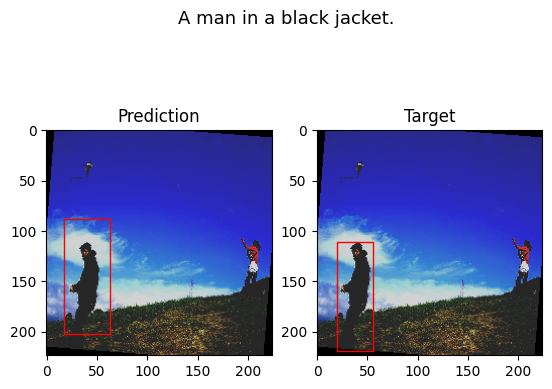

In [ ]:
el = 11

plot_one_example(im[el], outputs[el], targets[el], ann[el])

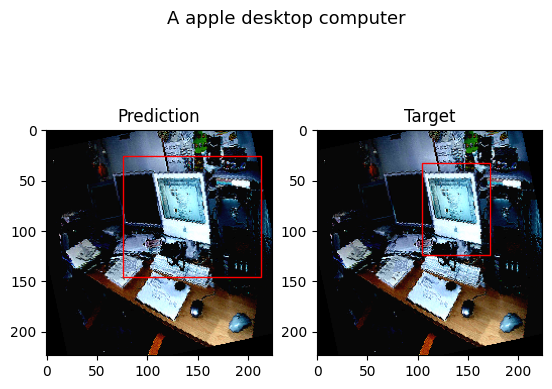

In [ ]:
el = 4

plot_one_example(im[el], outputs[el], targets[el], ann[el])

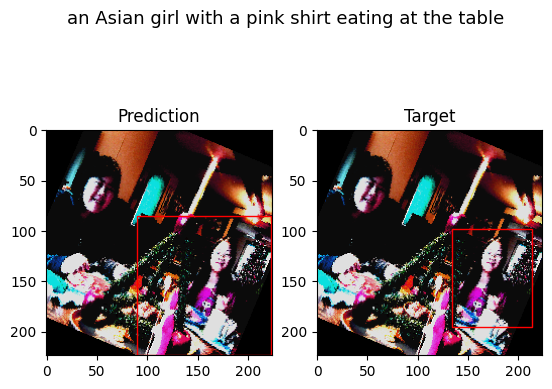

In [ ]:
el = 7

plot_one_example(im[el], outputs[el], targets[el], ann[el])

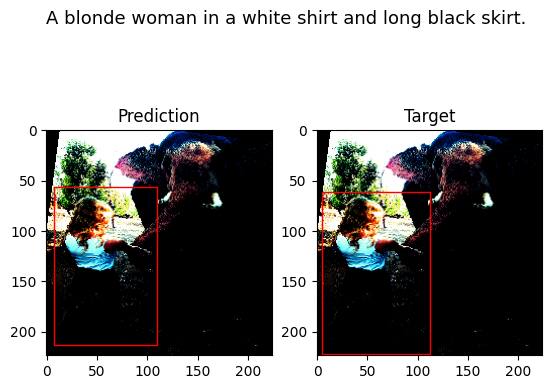

In [ ]:
el = 16

plot_one_example(im[el], outputs[el], targets[el], ann[el])

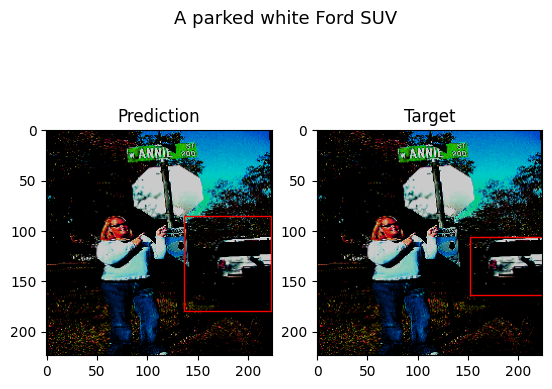

In [ ]:
el = 26

plot_one_example(im[el], outputs[el], targets[el], ann[el])

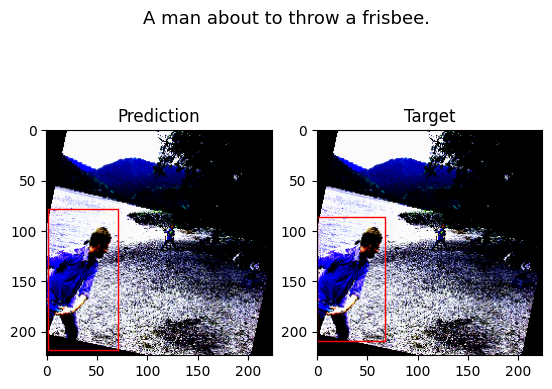

In [ ]:
el = 33

plot_one_example(im[el], outputs[el], targets[el], ann[el])

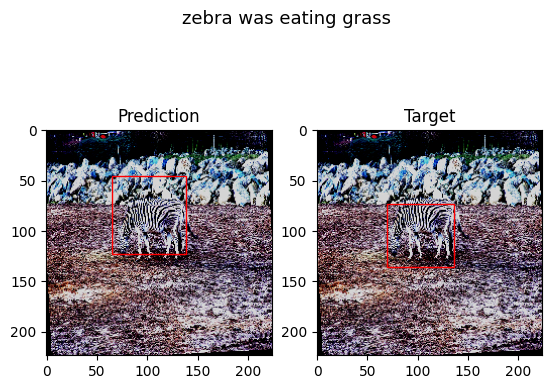

In [ ]:
el = 68

plot_one_example(im[el], outputs[el], targets[el], ann[el])

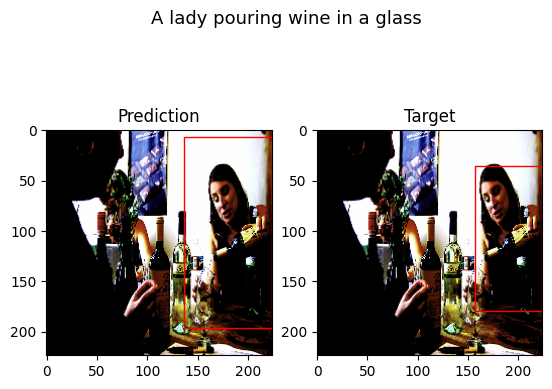

In [ ]:
el = 79

plot_one_example(im[el], outputs[el], targets[el], ann[el])

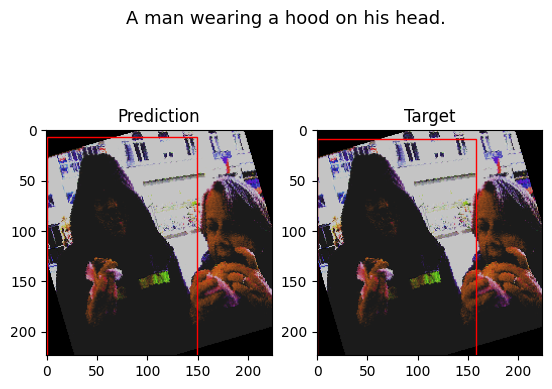

In [ ]:
el = 80

plot_one_example(im[el], outputs[el], targets[el], ann[el])

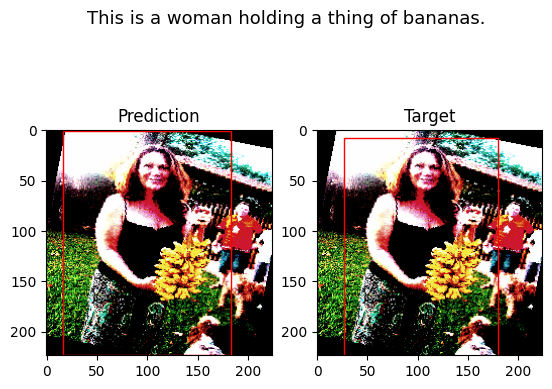

In [ ]:
el = 87

plot_one_example(im[el], outputs[el], targets[el], ann[el])

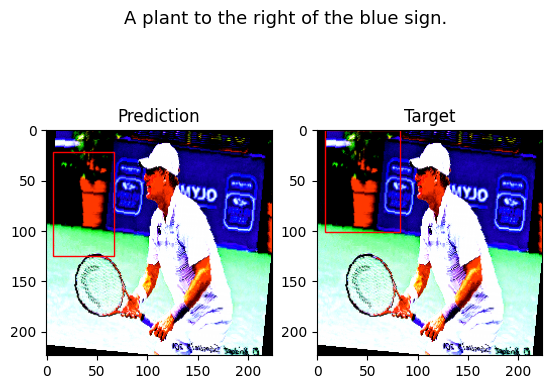

In [ ]:
el = 114

plot_one_example(im[el], outputs[el], targets[el], ann[el])

# Some impecise results

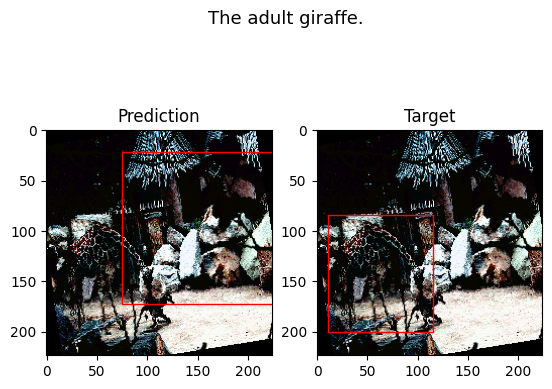

In [ ]:
el = 12

plot_one_example(im[el], outputs[el], targets[el], ann[el])

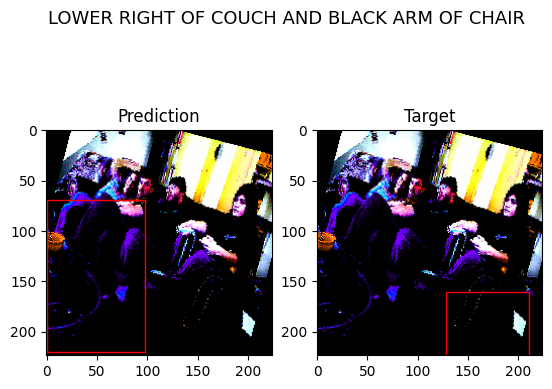

In [ ]:
el = 24

plot_one_example(im[el], outputs[el], targets[el], ann[el])

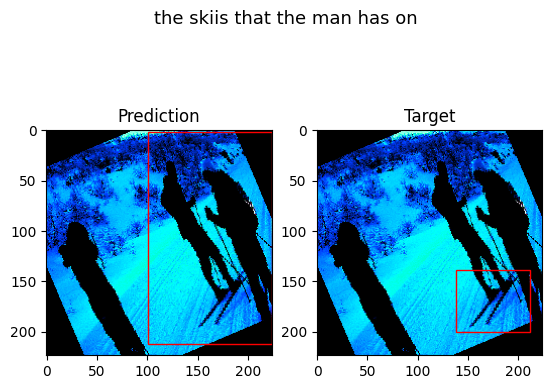

In [ ]:
el = 32

plot_one_example(im[el], outputs[el], targets[el], ann[el])

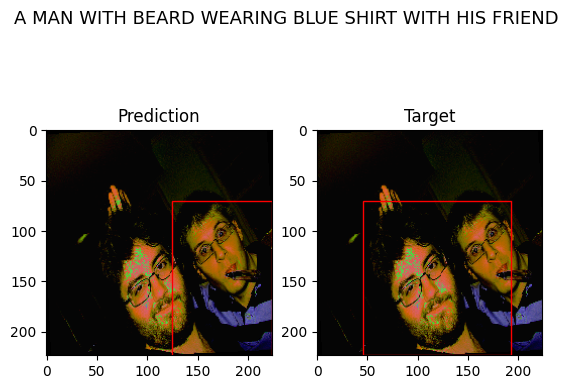

In [ ]:
el = 91

plot_one_example(im[el], outputs[el], targets[el], ann[el])

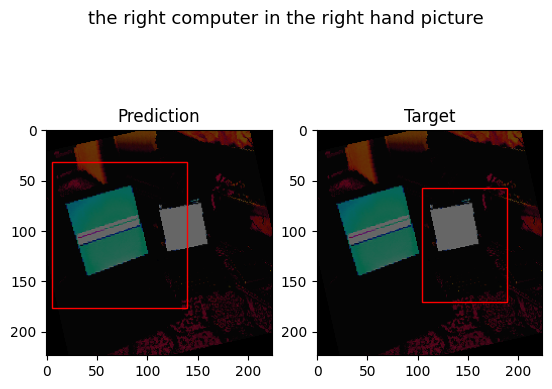

In [ ]:
el = 104

plot_one_example(im[el], outputs[el], targets[el], ann[el])

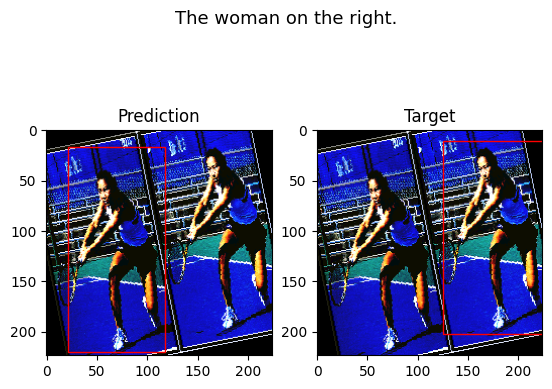

In [ ]:
el = 110

plot_one_example(im[el], outputs[el], targets[el], ann[el])

Some results, such as the last one, appears interesting. It suggest that the model is likely unable to distinguish left from right.